In [1]:
import sys
import time
import math
sys.path.insert(0, r'/home/danis/work/python_works/gamma_4/Scripts')
sys.path.insert(0, r'D:\Учеба\Практика\Диплом\gamma_4\Scripts')
import numpy as np
import pandas as pd
from materials import*
import matplotlib.pyplot as plt

Минимальная энергия: 1e-3
windows (w) or linux (l): w


Параметры пучков и спектры

In [2]:
linspace1 = np.linspace(0.035, 0.1, 25, dtype=np.float32)
linspace2 = np.geomspace(0.11, 3, 25, dtype=np.float32)

beams_energyes = []
beams_energyes.extend(linspace1)
beams_energyes.extend(linspace2)

In [3]:
m = 20
target = R(Material(m), 0.01)

brems = [target.brem(beams_energy) for beams_energy in beams_energyes]
brems_e = [brem * en for brem in brems]

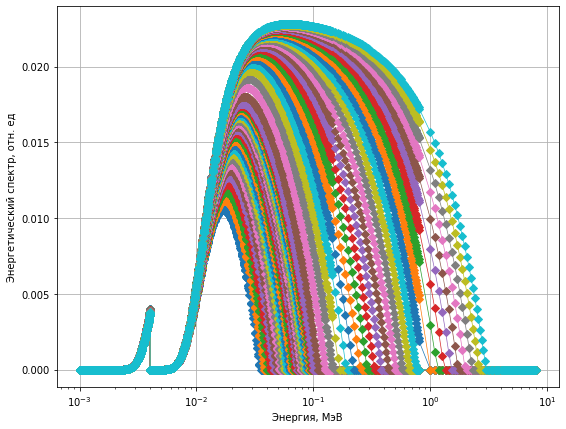

In [4]:
fig, ax = plt.subplots(figsize=(9, 7))

for br in brems_e:
    ax.plot(en, br, ls='-', marker='D', lw='0.7', ms=5)

# настройки графика
ax.set_xlabel('Энергия, МэВ', fontsize=10)
ax.set_ylabel('Энергетический спектр, отн. ед', fontsize=10)
ax.tick_params(axis='both', labelsize=10)

ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlim(1e-3, 0.1e0)
# ax.set_ylim(1e-7, 1.2)

ax.grid(True)

# fig.savefig('Тормозной спектр.jpg', bbox_inches='tight')

Номер первого канала и К-скачки

In [5]:
n = 11

In [6]:
# Индексы К скачков
EDGE = []
for i in range(1, len(en)):
    if en[i - 1] == en[i]:
        EDGE.append(i - 1)

In [7]:
EDGE.remove(EDGE[EDGE.index(Material(m).k_index())])

Уровни пропускания в К-крае

In [8]:
linspace3 = np.linspace(0.001, 0.9, 51)
for i, val in enumerate(linspace3):
    linspace3[i] = round(val, 5)
    
edge_max_values = []
edge_max_values.extend(linspace3)

Спектральные характеристики чувствительности каналов

In [9]:
edge_thiknesses = [[Material(i).lt(j) for i in range(n, 101)] for j in edge_max_values]

In [10]:
edge_regions = [[R(Material(i+n), edge_thiknesses[j][i]) for i in range(0, len(edge_thiknesses[j]))] for j in range(len(edge_thiknesses))]
resp_edges = [[val.f() for val in edge_regions[j]] for j in range(len(edge_regions))]

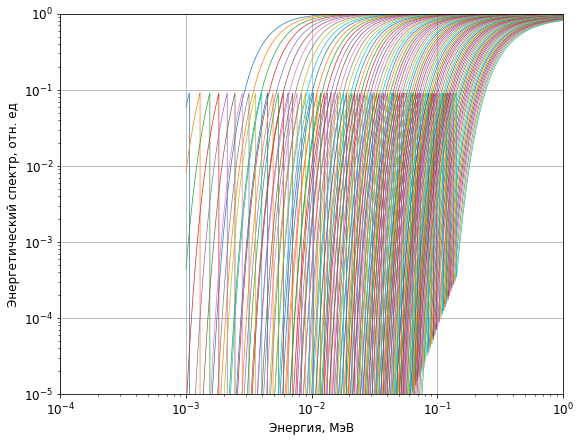

In [11]:
fig, ax = plt.subplots(figsize=(9, 7))

for i in resp_edges[5]:
    ax.plot(en, i, ls='-', lw='0.7', ms=5)

# настройки графика
ax.set_xlabel('Энергия, МэВ', fontsize=12)
ax.set_ylabel('Энергетический спектр, отн. ед', fontsize=12)
ax.tick_params(axis='both', labelsize=12)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(1e-4, 1e0)
ax.set_ylim(1e-5, 1e0)
ax.grid(True)

Матрицы задач

In [12]:
from garipov_deconvolution import get_coeff_simpson

In [ ]:
Matrixs = []

start_time = time.time()

for i in range(len(resp_edges)):
    print(f'({i}), время: {round(time.time() - start_time, 5)} секунд')
    matrix = []
    
    for response in resp_edges[i]:
        matrix.append(get_coeff_simpson(response, en, EDGE)[0])
    
    Matrixs.append(matrix)

(0), время: 0.0 секунд


Сигналы измерительных каналов

In [ ]:
new_en = get_coeff_simpson(resp_edges[0][0], en, EDGE)[1]

In [ ]:
def signals_from_one_spectrum(spectrum):
    
    start_time = time.time()
    signals_simpson = []
    
    # для каждой матрицы
    for i, matrix in enumerate(Matrixs):
        print(f'({i}), время: {round(time.time() - start_time, 5)} секунд')
        
        # сигналы для каждой задачи
        signals = []
        
        # для каждой строки в матрице
        for row in matrix:
            # значение одного сигнала
            signal = sum(row * np.interp(new_en, en, spectrum))
            signals.append(signal)
            
        signals_simpson.append(signals)
        
    return signals_simpson

Сигналы для каждого спектра

In [ ]:
spectrums_signals = []

for spectrum in brems_e:
    spectrums_signals.append(signals_from_one_spectrum(spectrum))

Восстановление спектров

In [ ]:
from garipov_deconvolution import Gold

In [ ]:
def deconvolution_one_spectrum(spectrum, signals_from_this_spectrum):
    
    sp = [0 for i in range(len(resp_edges))]
    dev = [0 for i in range(len(resp_edges))]
    norm = [0 for i in range(len(resp_edges))]
    
    start_time = time.time()
    
    for i in range(len(resp_edges)):
        print(f'({i}), время: {round(time.time() - start_time, 5)} секунд')
        sp[i], norm[i], dev[i] = Gold(Matrixs[i], signals_from_this_spectrum[i], en, spectrum, new_en, 1, 10000, w=True, d=False)[:3]
    return sp, dev

In [ ]:
fig, ax = plt.subplots(figsize=(9, 7))

ax.plot(range(90), spectrums_signals[0][0], ls='-', marker='D', lw='0.7', ms=5, color='orange')

# настройки графика
ax.set_xlabel('Энергия, МэВ', fontsize=10)
ax.set_ylabel('Энергетический спектр, отн. ед', fontsize=10)
ax.tick_params(axis='both', labelsize=10)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlim(1.e-5, 0.3e-4)
# ax.set_ylim(1e-7, 1.2)
ax.grid(True)

Скрипт

In [ ]:
SP, DEV = [], []

for j in range(len(brems_e)):
    sp, dev = deconvolution_one_spectrum(brems_e[j], spectrums_signals[j])
    SP.append(sp)
    DEV.append(dev)
    print(f'ВЫПОЛНЕНО {j+1} из {len(brems_e)}')

Сохранение данных

In [ ]:
np.save(f'K_{m}_SP.npy', SP)
np.save(f'K_{m}_DEV.npy', DEV)

Загрузка данных

Построение

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
D = np.array(DEV)
X,Y = np.meshgrid(edge_max_values, beams_energyes)
X, Ylog = np.meshgrid(edge_max_values, np.log10(beams_energyes))
Xlog, Ylog = np.meshgrid(np.log10(edge_max_values), np.log10(beams_energyes))

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': '3d'})
ax.plot_surface(X, Ylog, D, cmap='plasma', linewidth=0.3, edgecolors='k', shade=True)

ax.set_xlabel('Максимум пропускания в К-крае поглощения, отн. ед.')
ax.set_ylabel('Энергия электронов (десятичный логарифм), МэВ')
ax.set_zlabel('Ср.кв. ошибка восстановления, отн. ед.')
fig.tight_layout()

# угол зрения (линейный)
# ax.view_init(elev=20, azim=-135)

# угол зрения (логарифм)
ax.view_init(elev=25, azim=-45)

# fig.savefig('К_фильтры_3D.jpg', bbox_inches='tight')

Контурная карта

In [ ]:
linspace4 = np.geomspace(1e-2, 0.3, 20)
linspace5 = np.linspace(0.31, 1.4, 10)

In [ ]:
c_map_levels = []
c_map_levels.extend(linspace4)
c_map_levels.extend(linspace5)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

c_map = ax.contourf(X, Y, D, levels=c_map_levels)
borders = ax.contour(X, Y, D, colors='k', levels=c_map_levels, linewidths=0.3)
ax.clabel(borders, fontsize=7, colors='w')
fig.colorbar(c_map)
ax.set_yscale('log')

ax.set_xlabel('Максимум пропускания в К-крае поглощения, отн. ед.')
ax.set_ylabel('Энергия электронов, МэВ')

# fig.savefig('К_фильтры_контурная_карта.jpg', bbox_inches='tight')

Зависимость минимальной ошибки восстановления от граничной энерии спектра

In [ ]:
minimal_deviations = []

for i,val in enumerate(beams_energyes):
    min_value = min(DEV[i])
    minimal_deviations.append(min_value)

In [ ]:
fig, ax = plt.subplots(figsize=(9, 7))

ax.plot(beams_energyes, minimal_deviations, ls='-', marker='D', lw='0.7', ms=5, color='blue')

# настройки графика
ax.set_xlabel('Энергия электронов, МэВ', fontsize=10)
ax.set_ylabel('Минимальное среднеквадратичное отклонение по спектру, отн. ед', fontsize=10)
ax.tick_params(axis='both', labelsize=10)
ax.set_xscale('log')
# ax.set_yscale('log')
ax.grid(True)

# fig.savefig('К_фильтры_минимум_ошибки_восстановления_от_энергии_электронов.jpg', bbox_inches='tight')

In [ ]:
np.save(f'K_{m}_MIN.npy', minimal_deviations)